# Auto encodeurs


In [2]:
import tensorflow as tf

from keras.layers import Input, Rescaling, Reshape, Resizing, Flatten, Dense, Convolution2D, MaxPooling2D, Convolution2DTranspose, UpSampling2D
from keras import Model

from keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.utils import plot_model

from utils import *

from typing import tuple

# Principe général

Les auto encodeurs(ae) sont des architectures particulières en deeplearning qui peuvent notamment servir à débruiter des données. Ces données peuvent être un signal(e.g. voix, musique), des images, des vidéos, *etc.*. Ils peuvent également être utilisés afin de colorer des images qui seraient en noir et blanc par exemple.


L'architecture variera en fonction des données mais le principe général reste le même. Il s'agit de projeter les données en entrée dans un espace latent qui sera ensuite utilisé pour reconstituer l'information. Vous pouvez interpréter cet esapace latent commme un résumé des informations essentielles.

L'apprentissage consiste à donner en entrée des données bruitées et de les comparer en sortie avec les données attendues, non bruitées.

Pour notre exemple ici, nous sommes repartis du dataset mnist et nous avons bruité artificiellement les images avec la fonction random noise de [scikit-image](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise).

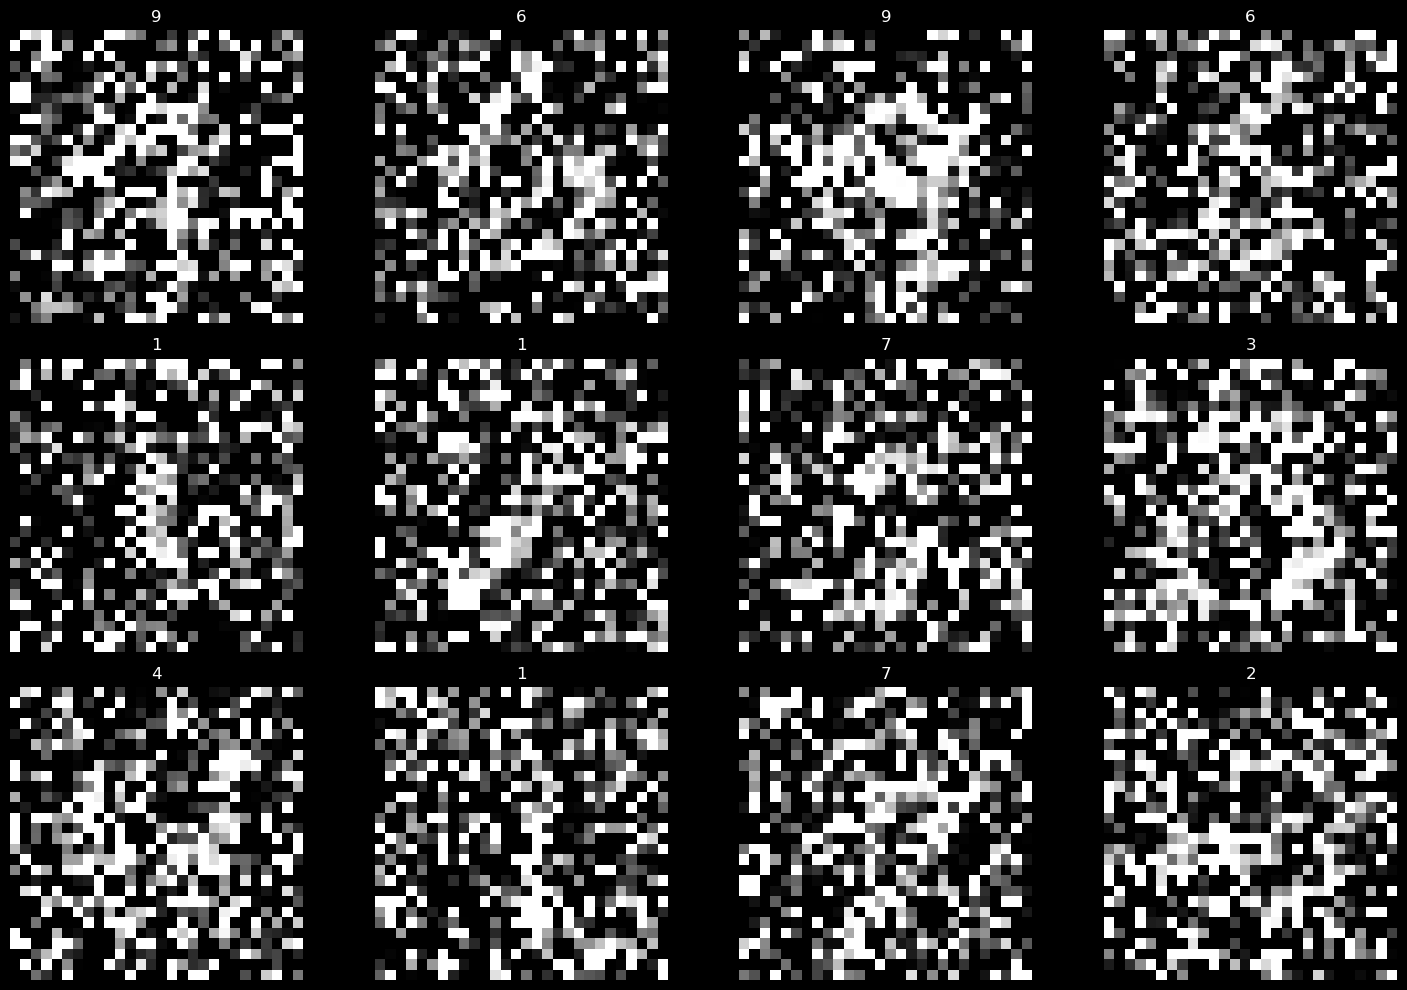

In [10]:
(x_train, y_train, train_label), (x_test, y_test, test_label) = load_mnist_noised(0.3, 0.3) ## see utils


plot_samples(x_train, train_label, 12) ## see utils

# Conception de l'architecture et choix de la fonction coût

## Encodeur
Un auto encodeur est construit en deux parties. Une première, que l'on appelle l'encodeur dont le rôle consiste à projeter les features dans un espace réduit. Cet espace réduit est parfois appelé espace latent. Cet espace latent peut être un simple vecteur d'une taille réduite.

On peut d'ailleurs faire un rapprochement avec la PCA puisque dans les deux cas, l'objectif est de réduire la quantité de dimensions ceci dit avec une différence majeure puisque que contrairement à la PCA, un encodeur peut suivre une approche non linéaire.

## Décodeur
La seconde partie, appelée le décodeur utilise l'espace latent afin de reconstruire le signal. Cet espace latent, si le modèle est correctement entraîné, devrait contenir l'essentiel de l'information (*i.e.* pas de bruit).

## Fonction coût
Le choix de la fonction coût dépend bien évidemment de l'objectif poursuivi. Dans notre cas, nous cherchons à débruiter des images et donc l'image de sortie doit ressembler à l'image attendue. Pour calculer cette ressemblance, on peut simplement calculer une erreur quadratique moyenne en comparant les valeurs des pixels prédits avec ceux attendus. 
(=regression: plus ou moins les mêmes valeurs, sans le bruit)

In [18]:
def prepocessing(input_shape: tuple[int, ...], 
                 target_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)
    x = Reshape(target_shape)(inputs)

    return  Model(inputs=inputs, outputs=x, name='preprocessing')

def encoder(input_shape: tuple[int, ...], 
            z_size: int ## latent-space
           ) -> Model:
    
    inputs = Input(input_shape)

    x = Convolution2D(32, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(2, padding='same')(x)

    x = Convolution2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2, padding='same')(x)

    x = Convolution2D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2, padding='same')(x)

    x = Flatten()(x)
    ### z_size == espace latent/reduit
    x = Dense(z_size, activation='relu')(x)
    
    ### ajouter autres couches pour le décodeur: 
    ### -- avoir le nombre de pixels suffisant pour reconstruire l'image 
    x = Dense(2048, activation='relu')(x)
    ### reshape pour pouvoir appliquer les convolutions 2DTranspose
    ### attention la shape pour la convolution/convolutionTranspose
    x = Reshape((4, 4, 128))(x) ## 4*4*128 = 2048

    return Model(inputs=inputs, outputs=x, name='encoder')
    
def decoder(input_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)
    ### (4,4,...)
    x = Convolution2DTranspose(128, 3, strides=2, padding='same', activation='relu')(inputs)
    ### ?(8,8)
    x = Convolution2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    ### ?(16,16)
    x = Convolution2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    ### ?(32,32)
    x = Convolution2DTranspose(1, 3, padding='same', activation='relu')(x)

    return Model(inputs=inputs, outputs=x, name='decoder')

def autoencoder(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    
    x = encoder(x.shape[1:], z_size)(x)
    x = decoder(x.shape[1:])(x)

    x = Resizing(28, 28)(x)

    return Model(inputs=inputs, outputs=x, name='autoencoder')

In [19]:
ae = autoencoder(x_train.shape[1:], (28, 28, 1), 40)
ae.compile(
    optimizer=Adam(),
    loss = MeanSquaredError()
)

# plot_model(ae, expand_nested=True, show_shapes=True, show_layer_activations=True)


Epoch 1/40


2023-06-25 11:21:58.261328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-25 11:21:58.794417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


94/94 [==============================] - 5s 26ms/step - loss: 0.0735 - val_loss: 0.0669
Epoch 2/40
94/94 [==============================] - 2s 21ms/step - loss: 0.0674 - val_loss: 0.0669
Epoch 3/40
94/94 [==============================] - 2s 25ms/step - loss: 0.0674 - val_loss: 0.0669
Epoch 4/40
94/94 [==============================] - 2s 24ms/step - loss: 0.0672 - val_loss: 0.0661
Epoch 5/40
94/94 [==============================] - 2s 24ms/step - loss: 0.0670 - val_loss: 0.0659
Epoch 6/40
94/94 [==============================] - 2s 23ms/step - loss: 0.0645 - val_loss: 0.0612
Epoch 7/40
94/94 [==============================] - 2s 23ms/step - loss: 0.0579 - val_loss: 0.0531
Epoch 8/40
94/94 [==============================] - 2s 25ms/step - loss: 0.0501 - val_loss: 0.0467
Epoch 9/40
94/94 [==============================] - 2s 23ms/step - loss: 0.0451 - val_loss: 0.0423
Epoch 10/40
94/94 [==============================] - 2s 23ms/step - loss: 0.0408 - val_loss: 0.0394
Epoch 11/40
94/94 [=

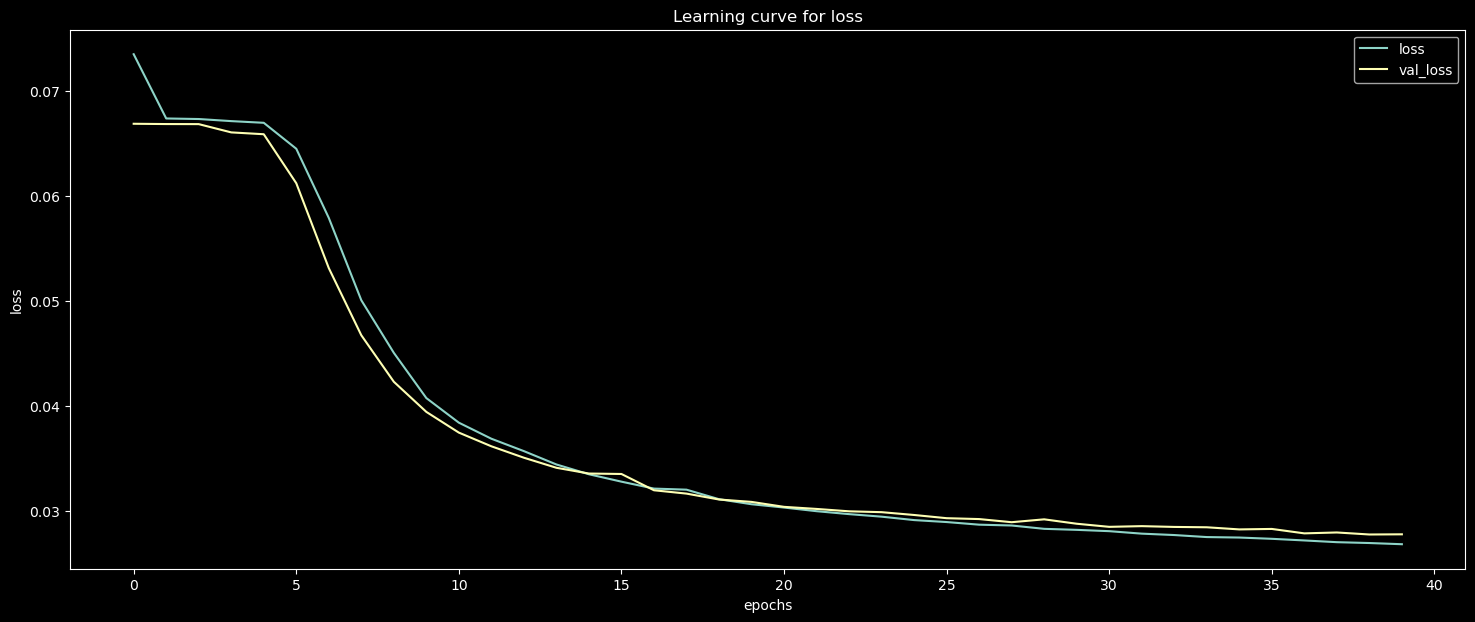

313/313 [==============================] - 1s 2ms/step


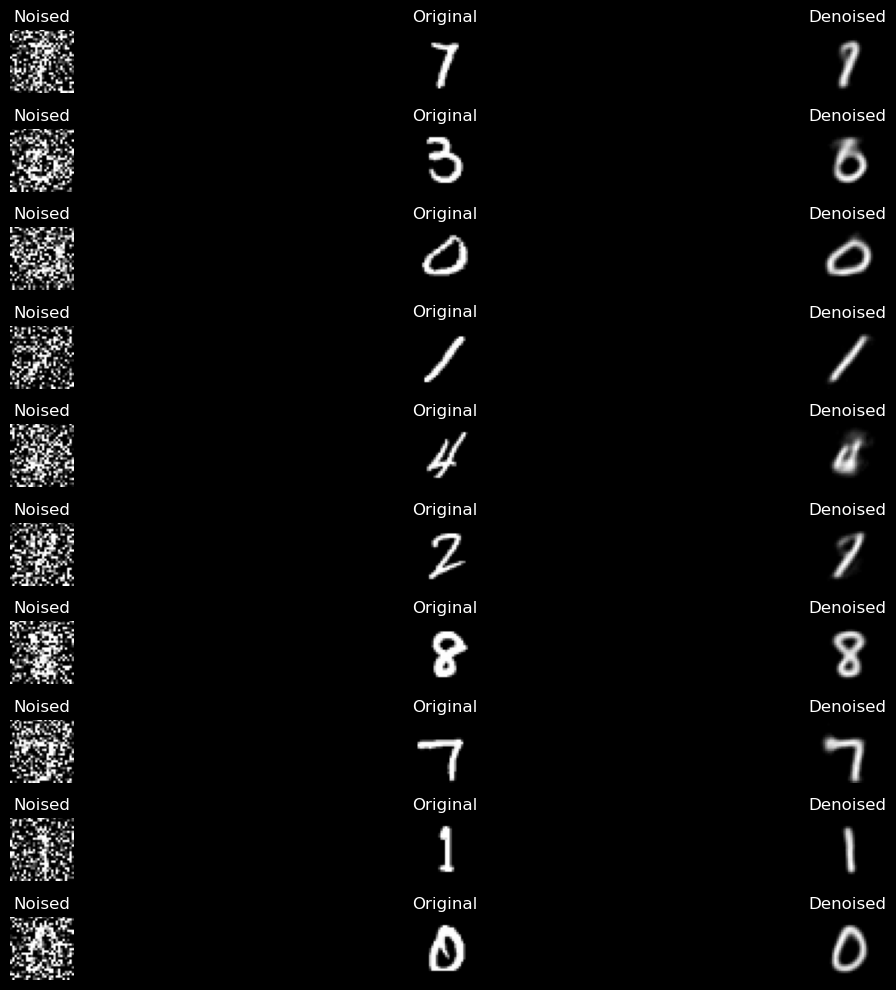

In [5]:

ae.fit(x_train ## noised images
       , y_train ## un noised/true images
       , batch_size=512, epochs=40, validation_split=.2)
get_lc(ae.history.history)

y_pred = ae.predict(x_test) ## x_test= noised images
plot_ae_results(10, x_test, y_test, y_pred)

## Alternatives possibles

- Nous aurions également pu utiliser de simples couches denses à la place des convolutions
- A la place des *convolutions2DTranspose*, nous pouvons utiliser des couches d'*upsampling* combinées à des couches de convolutions. A la différence des couches de convolutions tranposées, les couches d'upsampling en sont pas sujettes à un apprentissage.
- Des architectures plus complexes existent (*cfr.* unet)

In [6]:
def decoder_upsampling(input_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)

    x = Convolution2D(128, 3, padding='same', activation='relu')(inputs)
    x = UpSampling2D(2)(x)

    x = Convolution2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D(2)(x)

    x = Convolution2D(32, 3, padding='same', activation='relu')(x)
    x = UpSampling2D(2)(x)

    x = Convolution2D(1, 3, padding='same', activation='relu')(x)
    
    return Model(inputs=inputs, outputs=x, name='decoder_upsampling')

def autoencoder(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    x = encoder(x.shape[1:], z_size)(x)
    x = decoder_upsampling(x.shape[1:])(x)

    x = Resizing(28, 28)(x)

    return Model(inputs=inputs, outputs=x, name='autoencoder')


Epoch 1/40
47/47 [==============================] - 6s 46ms/step - loss: 0.0746 - val_loss: 0.0673
Epoch 2/40
47/47 [==============================] - 2s 40ms/step - loss: 0.0675 - val_loss: 0.0670
Epoch 3/40
47/47 [==============================] - 2s 40ms/step - loss: 0.0675 - val_loss: 0.0671
Epoch 4/40
47/47 [==============================] - 2s 40ms/step - loss: 0.0674 - val_loss: 0.0669
Epoch 5/40
47/47 [==============================] - 2s 39ms/step - loss: 0.0673 - val_loss: 0.0666
Epoch 6/40
47/47 [==============================] - 2s 39ms/step - loss: 0.0674 - val_loss: 0.0695
Epoch 7/40
47/47 [==============================] - 2s 40ms/step - loss: 0.0671 - val_loss: 0.0689
Epoch 8/40
47/47 [==============================] - 2s 38ms/step - loss: 0.0651 - val_loss: 0.0620
Epoch 9/40
47/47 [==============================] - 2s 37ms/step - loss: 0.0657 - val_loss: 0.0612
Epoch 10/40
47/47 [==============================] - 2s 37ms/step - loss: 0.0614 - val_loss: 0.0580
Epoch 11/

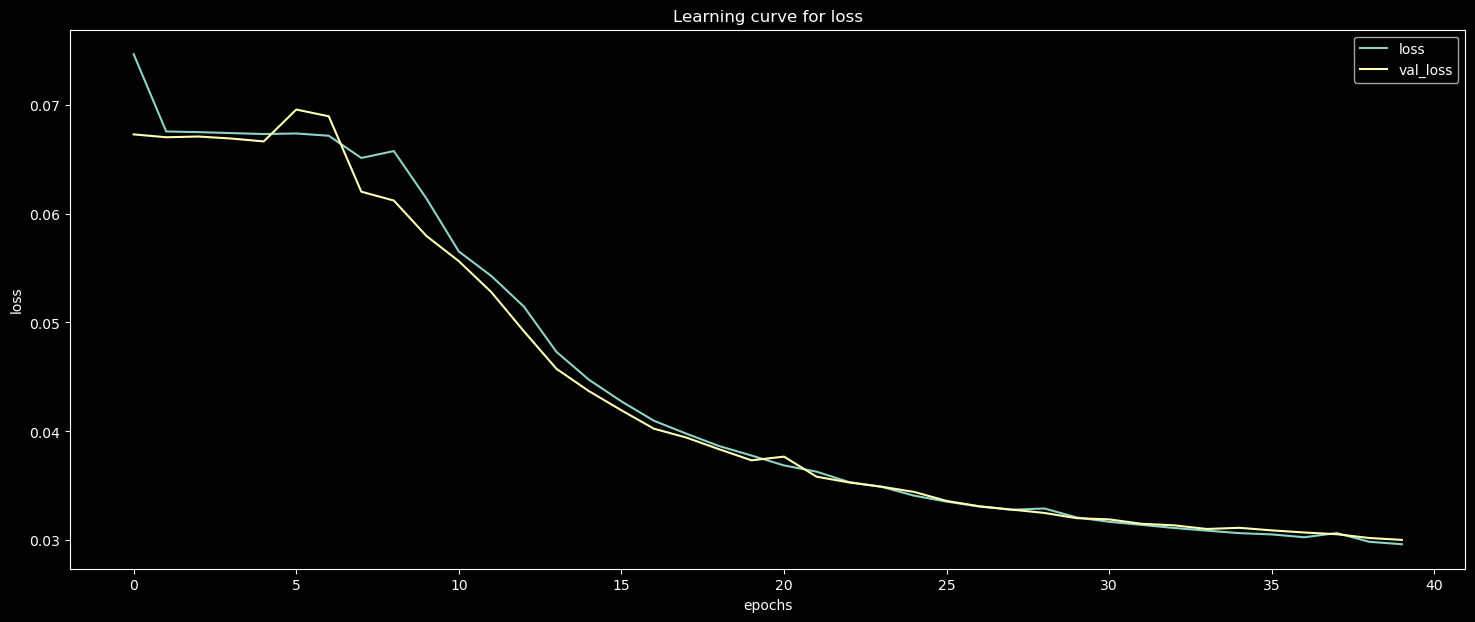

313/313 [==============================] - 1s 2ms/step


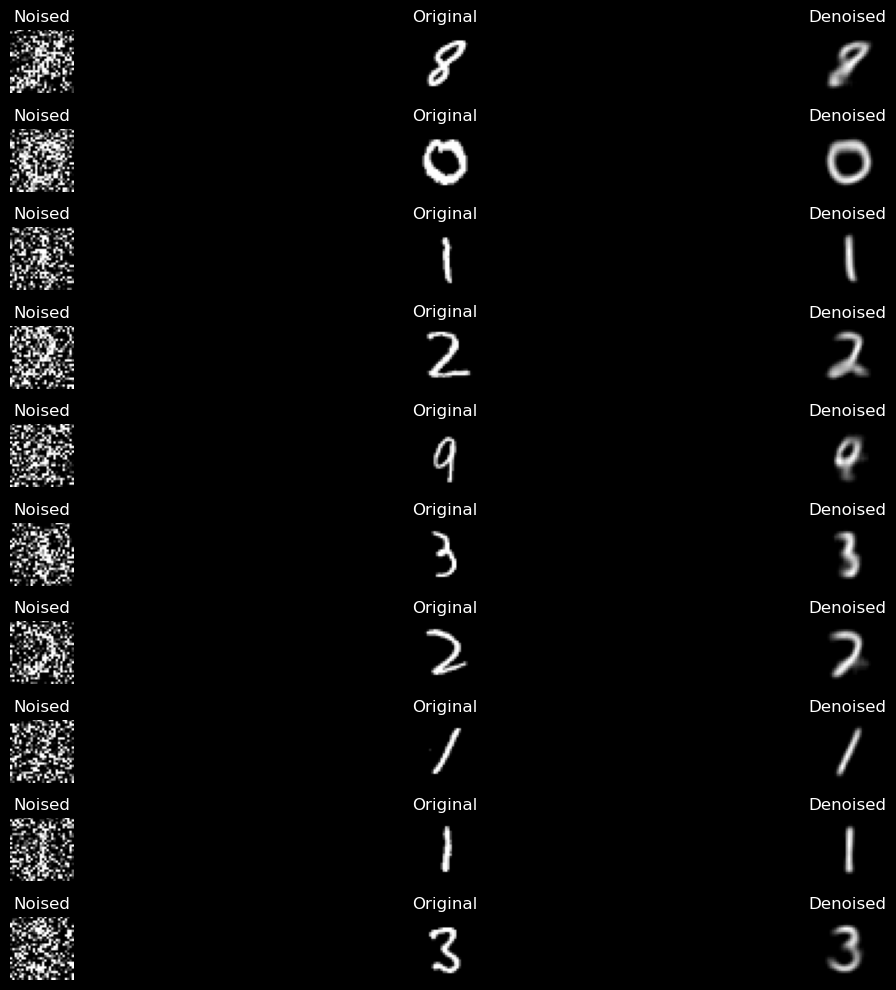

In [8]:
ae = autoencoder(x_train.shape[1:], (28, 28, 1), 50)
ae.compile(
    optimizer=Adam(),
    loss = MeanSquaredError()
)

# plot_model(ae, show_shapes=True, expand_nested=True)

ae.fit(x_train, y_train, batch_size=1024, epochs=40, validation_split=.2)
get_lc(ae.history.history)

y_pred = ae.predict(x_test)
plot_ae_results(10, x_test, y_test, y_pred)

## Utiliser notre modèle pour débruiter ET classer des images


In [24]:
def classifier(input_shape: tuple[int, ...], n_labels: int) -> Model:
    inputs = Input(input_shape)

    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(n_labels, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=x, name='classifier')

def autoencoder_classifier(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int, n_labels: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    x_encoded = encoder(x.shape[1:], z_size)(x)

    ### use the result of encoding to decode: reconstruct image
    denoised = decoder(x_encoded.shape[1:])(x_encoded)
    denoised = Resizing(28, 28, name='denoised_out')(denoised)
    
    ### reuse the result of encoding for a classification
    classifications = classifier(x_encoded.shape[1:], n_labels)(x_encoded) 

    return Model(inputs=inputs, outputs=[denoised, classifications], name='autoencoder')


In [29]:
denoiser_classifier = autoencoder_classifier((28, 28), (28, 28, 1), 20, 10)

denoiser_classifier.compile(
    optimizer=Adam(),
    loss = {
        'denoised_out': MeanSquaredError(), ## metric for the decoder-part of the autoencoder
        'classifier': SparseCategoricalCrossentropy() ## metric for the classification       
    },
    metrics = {
        'classifier': 'accuracy'
    }
)

denoiser_classifier.fit(x_train, ## noised images
                        {
                            'denoised_out': y_train, ## un-noised images
                            'classifier': train_label ## label
                        },
                        epochs=50, batch_size=1024)

Epoch 1/50
59/59 [==============================] - 2s 23ms/step - loss: 2.4918 - denoised_out_loss: 0.1900 - classifier_loss: 2.3018 - classifier_accuracy: 0.1120
Epoch 2/50
59/59 [==============================] - 1s 22ms/step - loss: 2.4685 - denoised_out_loss: 0.1671 - classifier_loss: 2.3014 - classifier_accuracy: 0.1124
Epoch 3/50
59/59 [==============================] - 1s 22ms/step - loss: 2.4679 - denoised_out_loss: 0.1665 - classifier_loss: 2.3014 - classifier_accuracy: 0.1124
Epoch 4/50
59/59 [==============================] - 1s 22ms/step - loss: 2.4678 - denoised_out_loss: 0.1665 - classifier_loss: 2.3013 - classifier_accuracy: 0.1124
Epoch 5/50
59/59 [==============================] - 1s 22ms/step - loss: 2.4678 - denoised_out_loss: 0.1665 - classifier_loss: 2.3013 - classifier_accuracy: 0.1124
Epoch 6/50
59/59 [==============================] - 1s 22ms/step - loss: 2.4678 - denoised_out_loss: 0.1665 - classifier_loss: 2.3013 - classifier_accuracy: 0.1124
Epoch 7/50
59/59